In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set seaborn default parameters for plots
# may have to pip install it: 
# pip install pycountry
import pycountry
import os
data_folder = 'data'
gender_dict = {'b': 'both', 'f': 'female', 'm': 'male'}

/Users/jonathandoenz/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_country_name(country_code, alpha=True):
    if alpha:
        return pycountry.countries.get(alpha_3=country_code).name
    else:
        return pycountry.countries.get(numeric=country_code).name

## Data preparation

In [3]:
file_path = os.sep.join([data_folder, 'Abel', 'migflows_allcountries_gender_separated_1990_2015.csv'])
df = pd.read_csv(file_path)
print(f'Number of rows in original dataset: {df.shape[0]}.')

# select only time intervals of 5 years from 1990 to 2015 
df = df[(df.interval == 5) & (df.year0 >= 1990)]
print(f'Number of rows after filtering time interval: {df.shape[0]}.')

# remove irrelevant and redundant columns
df.drop(columns=['stock', 'demo', 'interval', 'orig_code', 'dest_code'], inplace=True)

# get all countries in dataset
countries = set(df.orig.unique()).union(df.dest.unique())
print(f'There are {len(countries)} countries in MigrFlowSex dataset.')

iso_countries = {country.alpha_3 for country in pycountry.countries}
not_iso_countries = countries - iso_countries
print(f'There are {len(not_iso_countries)} not-ISO countries.')

# remove not-ISO countries
print(f"Let's remove them.")
df = df[~(df['orig'].isin(not_iso_countries) | df['dest'].isin(not_iso_countries))]
print(f'Number of rows after removing non-ISO countries {df.shape[0]}.')

countries_clean = set(df.orig.unique()).union(df.dest.unique())
assert len(countries_clean) == (len(countries) - len(not_iso_countries))
print(f'There are {len(countries_clean)} countries after removal.')

df_out = pd.pivot_table(df, values='flow', index=['year0', 'sex', 'orig'], columns='dest')
print(f'Number of rows in out-flow dataset: {df_out.shape[0]}.')
# compute total out-flow `sum_out` for each country
df_out['sum_out'] = df_out.sum(axis=1)
# compute maximum out-flow `max_out` for each country
df_out['max_out'] = df_out.max(axis=1)
# sort according to cumulative outflow
df_out = df_out.sort_values('sum_out', ascending=False).sort_index(level=[0, 1], sort_remaining=False)

df_in = pd.pivot_table(df, values='flow', index=['year0', 'sex', 'dest'], columns='orig')
print(f'Number of rows in in-flow dataset: {df_in.shape[0]}.')
# compute total in-flow `sum_in` for each country
df_in['sum_in'] = df_in.sum(axis=1)
# compute maximum in-flow `max_in` for each country
df_in['max_in'] = df_in.max(axis=1)
# sort according to cumulative inflow
df_in = df_in.sort_values('sum_in', ascending=False).sort_index(level=[0, 1], sort_remaining=False)

# select only sum and max flows
df_out_thin = df_out[['sum_out', 'max_out']]
df_in_thin = df_in[['sum_in', 'max_in']]

# join flows in and out in single dataframe `df_thin`
df_thin = df_in_thin.copy()
df_thin.index.rename(['year0', 'sex', 'orig'], inplace=True)
df_thin = df_thin.join(df_out_thin, how='inner')

# add population of each country for each time interval
file_path = os.sep.join([data_folder, 'Abel', 'pop.csv'])
df_pop = pd.read_csv(file_path)
df_pop.drop(columns='name', inplace=True)
df_pop.rename(columns={'year': 'year0', 'alpha3': 'orig'}, inplace=True)
df_pop.set_index(['year0', 'orig'], inplace=True)

# join population data with flows
df_thin = df_thin.merge(df_pop, how='inner', left_on=['year0', 'orig'], right_index=True)
# df_thin = df_thin.merge(df_pop, how='left', left_on=['year0', 'orig'], right_index=True)

df_thin.isnull().sum()

Number of rows in original dataset: 10321454.
Number of rows after filtering time interval: 4901986.
There are 204 countries in MigrFlowSex dataset.
There are 4 not-ISO countries.
Let's remove them.
Number of rows after removing non-ISO countries 4755853.
There are 200 countries after removal.
Number of rows in out-flow dataset: 2943.
Number of rows in in-flow dataset: 2943.


sum_in     0
max_in     0
sum_out    0
max_out    0
pop        0
dtype: int64

## Data analysis

### Let's first look at the countries with the highest number of migrant in-flows and out-flows respectively
We constrained the analysis to the most recent time interval: 2010-2015, and for men and women aggregated together.

In [4]:
def get_df_with_k_max_coutries(df_thin, colname, year0, gender, k, normalize=False):
    df_thin = df_thin.copy()
    if normalize:
        df_thin[colname] = df_thin[colname] / df_thin['pop']
        df_thin.drop(columns=[col for col in df_thin.columns if col not in [colname, 'pop']], inplace=True)
    return df_thin.sort_values(colname, ascending=False) \
        .sort_index(level=['year0', 'sex'], sort_remaining=False) \
        .loc[(year0, gender, slice(None)), :] \
        .head(k)

In [5]:
def plot_country_bars(df, operator, direction, ax, normalize=False):
    colname = f'{operator}_{direction}'
    country_codes = df.index.get_level_values('orig').values
    year0 = df.index.get_level_values('year0')[0]
    gender = df.index.get_level_values('sex')[0]
    time_interval = f'{year0}-{year0 + 5}'
    ax.bar(country_codes, df[colname].values)
    if ~normalize:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_title(f'Countries with largest {"normalized " if normalize else ""}'
                 f'{direction}-flow of {gender_dict[gender] + " " if gender != "b" else ""}'
                 f'migrants in {time_interval}', pad=20)
    ax.set_xlabel('Country')
    ax.set_ylabel(f'{"Normalized number" if normalize else "Number"} of migrants flowing {direction}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # add text box with country names:
    country_names_str = '\n'.join([f'{country_code}: {get_country_name(country_code)}' for country_code in country_codes])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(1, 1, country_names_str, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=props)
    
    return ax

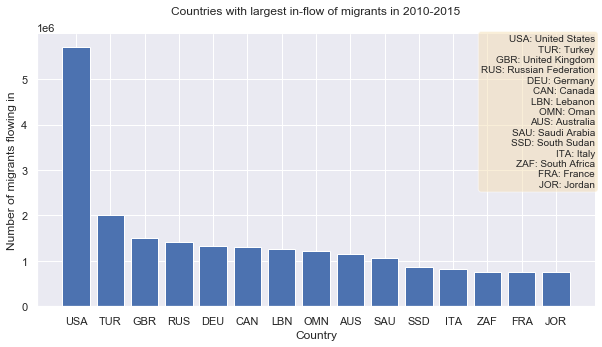

In [6]:
gender = 'b'
operator = 'sum'
direction = 'in'
colname = f'{operator}_{direction}'
year0 = 2010
k = 15
df_max_inflowers = get_df_with_k_max_coutries(df_thin, colname, year0, gender, k)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_country_bars(df_max_inflowers, operator, direction, ax)

We can see that the USA is by large the country with the largest in-flow of people with a total flow almost 3 times larger than the one from the second country, Turkey.

Let's look at out-flows now.

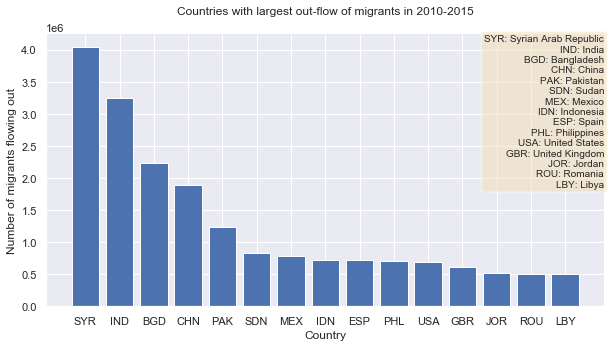

In [7]:
gender = 'b'
operator = 'sum'
direction = 'out'
colname = f'{operator}_{direction}'
year0 = 2010
k = 15
df_max_outflowers = get_df_with_k_max_coutries(df_thin, colname, year0, gender, k)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_country_bars(df_max_outflowers, operator, direction, ax)

Here we observe that the largest outflow is from Syria, which undergoes a civil war since the March 2011 and is still ongoing at the time of writing (April 2020). 
This war caused a vast number of Syrians to flee to neighbouring countries such as Turkey, Lebanon, Jordan, as can be seen from their presence in the top ranking of inflow countries above.

The four countries following Syria, India, Bangladesh, China and Pakistan are all among the top 8 most populated countries. 
Therefore it's not so surprising to see them here.

### Let's do the same but normalizing the flows with the local population of the countries

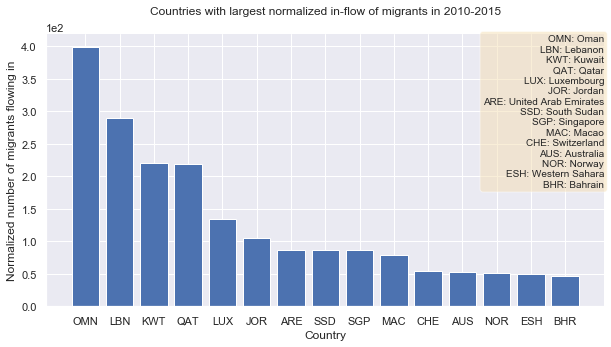

In [8]:
gender = 'b'
operator = 'sum'
direction = 'in'
colname = f'{operator}_{direction}'
year0 = 2010
k = 15
df_max_outflowers = get_df_with_k_max_coutries(df_thin, colname, year0, gender, k, normalize=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_country_bars(df_max_outflowers, operator, direction, ax, normalize=True)

Here we notice the prevalence of Arab states of the Persian Gulf countries such as Oman occupying the first position, Kuwait, Qatar, United Arab Emirates, Bahrain. 
These countries heavily rely on foreign migrant workers since the oil boom of the 1970s ([article about this](https://www.theturbantimes.com/2018/03/07/migration-in-oman/)).

Lebanon is here because of the migrants from Syria due to the civil war as argued above.
Jordan also had many migrants from Syria but also from Libya.

South Sudan's presence is explained by the [Sudanese conflict in South Kordofan and Blue Nile](https://en.wikipedia.org/wiki/Sudanese_conflict_in_South_Kordofan_and_Blue_Nile#Emigration) for which they received many refugees from Sudan.

We also note the presence of high-income countries that have small populations such as Luxembourg, Switzerland, Singapore, Macao, Norway.
This may suggest that immigration is benefitial to high-income countries.

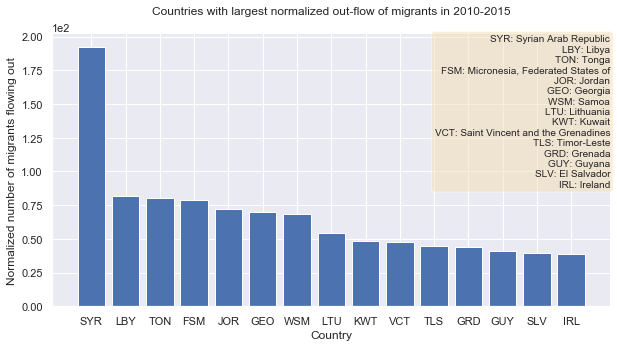

In [9]:
gender = 'b'
operator = 'sum'
direction = 'out'
colname = f'{operator}_{direction}'
year0 = 2010
k = 15
df_max_outflowers = get_df_with_k_max_coutries(df_thin, colname, year0, gender, k, normalize=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_country_bars(df_max_outflowers, operator, direction, ax, normalize=True)

Syria's outflow of people is very large compared to its population size. 
Its outflow is more than twice larger than the second ranked country, Libya, which also underwent a civil war in 2011 and a second one from 2014 to present.

Interestingly, several Pacific islands' countries such as Tonga, Micronesia, and Samoa are among the 10 countries with the largest outflows per-capita.

### Now let's do the same analysis while looking at female and male flows side by side

We saw before that Oman had a very large inflow of migrants. Here we can see that they consist in majority of men.



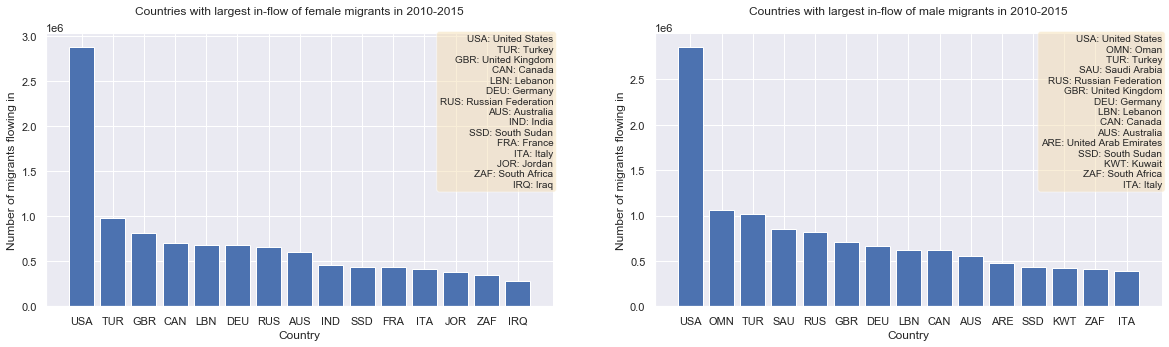

In [10]:
gender = 'f'
operator = 'sum'
direction = 'in'
colname = f'{operator}_{direction}'
year0 = 2010
k = 15
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df2plot = get_df_with_k_max_coutries(df_thin, colname, year0, 'f', k)
# c1 = df2plot.index.get_level_values(level=2)
plot_country_bars(df2plot, operator, direction, ax[0])
df2plot = get_df_with_k_max_coutries(df_thin, colname, year0, 'm', k)
# c2 = df2plot.index.get_level_values(level=2)
plot_country_bars(df2plot, operator, direction, ax[1])

The four countries that are only present in the women's top ranking are India, France, Jordan and Iraq.

On the other hand, the four countries present only in the men's top ranking are Oman, Saudi Arabia, United Arab Emirates and Kowait.
People migrating to these Persian Gulf countries hence appear to be mostly men. 

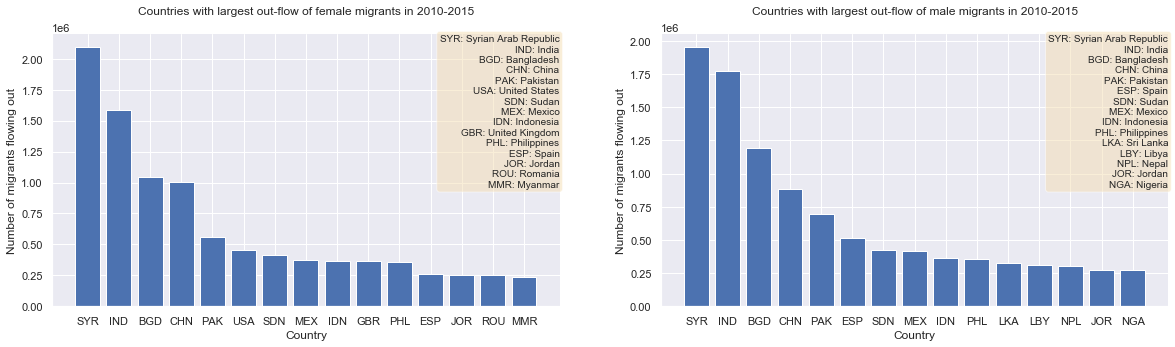

In [11]:
gender = 'f'
operator = 'sum'
direction = 'out'
colname = f'{operator}_{direction}'
year0 = 2010
k = 15
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df2plot = get_df_with_k_max_coutries(df_thin, colname, year0, 'f', k)
# c1 = df2plot.index.get_level_values(level=2)
plot_country_bars(df2plot, operator, direction, ax[0])
df2plot = get_df_with_k_max_coutries(df_thin, colname, year0, 'm', k)
# c2 = df2plot.index.get_level_values(level=2)
plot_country_bars(df2plot, operator, direction, ax[1])

We can see again that most of the largest ouflowing countries are similar for women and men. 
Let's look at the differences of flows between men and women for every country now.

### Flow differences between women and men for each country

In [12]:
# compute difference female minus male (cumulative) migration flows
# outflow
df_out_thin_maleFemale = df_out_thin.pivot_table(values='sum_out', index=['year0', 'orig'], columns='sex')
df_out_thin_maleFemale['female_minus_male'] = df_out_thin_maleFemale.f - df_out_thin_maleFemale.m

# inflow
df_in_thin_maleFemale = df_in_thin.pivot_table(values='sum_in', index=['year0', 'dest'], columns='sex')
df_in_thin_maleFemale['female_minus_male'] = df_in_thin_maleFemale.f - df_in_thin_maleFemale.m

# prepare to join the two dfs: copy and change index name
df_in_thin_maleFemale_c = df_in_thin_maleFemale.copy()
df_in_thin_maleFemale_c.index.rename(['year0', 'orig'], inplace=True)
# join
df_thin_maleFemale = df_in_thin_maleFemale_c.join(df_out_thin_maleFemale, how='inner', lsuffix='_in', rsuffix='_out')

# add population information
df_thin_maleFemale = df_thin_maleFemale.join(df_pop, how='inner')
# df_thin_maleFemale.head()

In [13]:
def get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger=False, normalize=False):
    """Return a dataframe filtered for:
    the given year0 time interval, 
    the desired flow's direction (in or out),
    and ordered by: 
    the decreasing (female - male) difference if maleLarger is False, 
    and decreasing (male - female) dfference if maleLarger is True."""
    df_thin_maleFemale = df_thin_maleFemale.copy()
    colname = f'female_minus_male_{direction}'
    if normalize:
        df_thin_maleFemale[colname] = df_thin_maleFemale[colname] / df_thin_maleFemale['pop']
    cols2keep = [col for col in df_thin_maleFemale.columns if col.endswith(f'_{direction}')]
    cols2keep.append('pop')
    df_thin_maleFemale.drop(columns=[col for col in df_thin_maleFemale.columns if col not in cols2keep], inplace=True)
    
    return df_thin_maleFemale.sort_values(colname, ascending=maleLarger) \
        .sort_index(level='year0', sort_remaining=False) \
        .loc[(year0, slice(None)), :] \
        .head(k)

In [14]:
def plot_country_bars_maleFemale(df, direction, ax, maleLarger=False, normalize=False):
    colname = f'female_minus_male_{direction}'
    year0 = df.index.get_level_values('year0')[0]
    time_interval = f'{year0}-{year0 + 5}'
    country_codes = df.index.get_level_values('orig').values
    ax.bar(country_codes, np.abs(df[colname].values))
    if ~normalize:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_title(f'Countries with largest {"normalized" if normalize else ""} difference in {direction}-flow between women and men in {time_interval}', pad=20)
    ax.set_xlabel('Country')
    ax.set_ylabel(f'{"Normalized difference " if normalize else "Difference "}' 
                  f'{"(male - female)" if maleLarger else "(female - male)"} flowing {direction}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # add text box with country names:
    country_names_str = '\n'.join([f'{country_code}: {get_country_name(country_code)}' for country_code in country_codes])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(1, 1, country_names_str, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=props)
    
    return ax

### Let's first concentrate on the countries with more female than male migrating

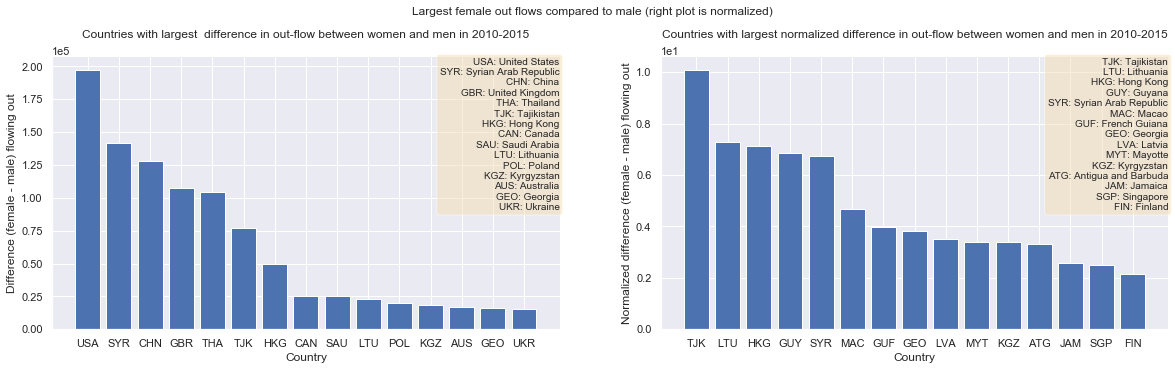

In [15]:
direction = 'out'
year0 = 2010
k = 15
maleLarger = False
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction} flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)

In [ ]:
direction = 'in'
year0 = 2010
k = 15
maleLarger = False
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction} flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)

### Countries with more male than female migrating

In [ ]:
direction = 'out'
year0 = 2010
k = 15
maleLarger = True
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction}flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)

In [ ]:
direction = 'in'
year0 = 2010
k = 15
maleLarger = True
df2plot = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=False)
df2plot_norm = get_df_with_k_max_coutries_maleFemale(df_thin_maleFemale, direction, year0, k, maleLarger, normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Largest {"male" if maleLarger else "female"} {direction}flows '
             f'compared to {"female" if maleLarger else "male"} (right plot is normalized)', y=1.02)
plot_country_bars_maleFemale(df2plot, direction, ax[0], maleLarger, normalize=False)
plot_country_bars_maleFemale(df2plot_norm, direction, ax[1], maleLarger, normalize=True)